# Preprocessing #
Evan Petrimoulx\
Sania Palaha\
Data Analytics 1

In [1]:
import os
import cv2 as cv
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

from skimage import color
from matplotlib.image import imread
from numpy.fft import fft2, fftshift
from scipy.fft import fftshift
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [2]:
image_pixel_array = [] 
for folder in os.listdir('Plant_leave_diseases_dataset_without_augmentation'):
    if folder.endswith(".DS_Store"):
        continue
    for file in os.listdir('Plant_leave_diseases_dataset_without_augmentation/' + folder):
        if file.endswith(".jpg"):
            image = imread('Plant_leave_diseases_dataset_without_augmentation/' + folder + '/' + file)
            image_pixel_array.append(image)
            
image_pixel_array = np.array(image_pixel_array)

Dataset is now loaded and stored as a 3D numpy array (image, (horizontal pixels, vertical pixels)). Now we can perform the data preprocessing, and store the dataset.

### Fourier Transform Feature ###

(1500, 256, 256, 3)


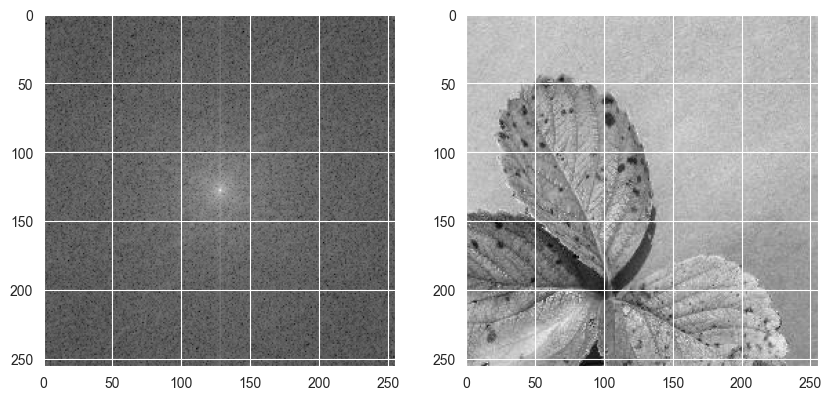

In [15]:
# Fourier Transform Information
Fourier_Data = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    grayscale_image = color.rgb2gray(image_pixel_array[image]) # Convert to greyscale
    image_FT = fftshift(fft2(fftshift(grayscale_image))) # Compute 2D Fourier Transform
    Fourier_Data.append(image_FT)                # Append FT data to the FT_Data list. This will be added as a column in the Dataframe


# Proof of concept: (Can remove)


plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(Fourier_Data[-1])), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(grayscale_image, cmap='gray')
plt.show()

### Contrast Enhancement ###

### Noise Reduction ###

### Edge Detection ###

(1500, 256, 256, 3)


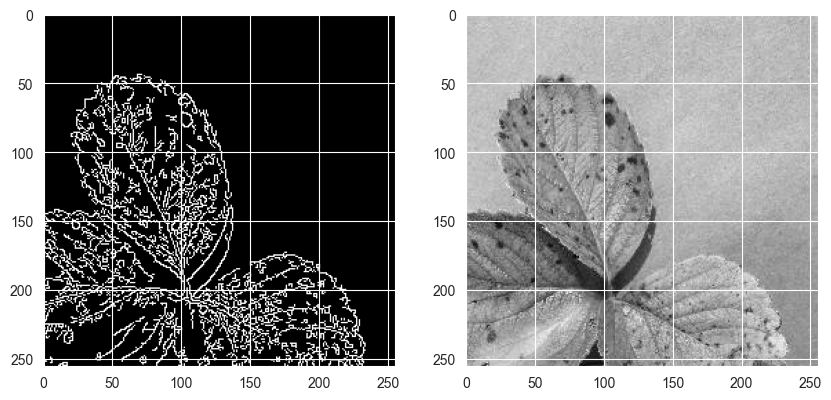

In [19]:
Edges = []
num_images = image_pixel_array.shape[0]

print(image_pixel_array.shape)

for image in range(num_images):
    gray_image = color.rgb2gray(image_pixel_array[image])  # Convert to grayscale
    gray_image = (gray_image * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
    edges = cv.Canny(gray_image, 100, 220)
    Edges.append(edges)  


plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(Edges[-1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.show()

### Combining Into Overall Dataframe ###